<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    System 2 - Homework 3<br>
<font color=2565AE size=5>
    Spring 2025<br>
<font color=3C99D size=5>
    Graph RAG <br>

### Full Name: Danial Parnian
---




In this Notebook, we'll explore the implementation of the GraphRAG (Graph-based Retrieval-Augmented Generation) approach to query-focused summarization, as described in the research paper `"From Local to Global: A GraphRAG Approach to Query-Focused Summarization"` by Darren Edge et al. This method is designed to generate comprehensive and diverse answers to global questions over entire text corpora by leveraging a graph-based text index and an LLM (Large Language Model).

We'll walk through a Python-based implementation that includes key steps from the paper, demonstrating how to process documents, build a graph, detect communities, and generate a final answer to a query.

Overview of the proposed Pipeline:
![GraphRAG](https://drive.google.com/uc?export=view&id=16Pv1vt_yY6u9ARodmnkbRmQttcpnjB18)

In [1]:
!pip install -q networkx leidenalg cdlib python-igraph pypdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 32.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.6/263.6 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 88.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 99.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 83.0 MB/s eta 0:00:00:00:01


In [2]:
%%capture --no-stderr
!pip install langchain-opentutorial

In [3]:
from langchain_opentutorial import package

package.install(
    [
        "langchain_core",
        "langchain_community",
        "langchain-graphrag",

    ],
    verbose=False,
    upgrade=False,
)

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.12.0 which is incompatible.
ydata-profiling 4.16.1 requires matplotlib<=3.10,>=3.5, but you have matplotlib 3.10.3 which is incompatible.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.7.0 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.0 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is 

In [4]:
# Download and save sample PDF file to ./data directory
import requests
import os

def download_pdf(url, save_path):
    """
    Downloads a PDF file from the given URL and saves it to the specified path.

    Args:
        url (str): The URL of the PDF file to download.
        save_path (str): The full path (including file name) where the file will be saved.
    """
    try:
        # Ensure the directory exists
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

        # Download the file
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Raise an error for bad status codes

        # Save the file to the specified path
        with open(save_path, "wb") as file:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)

        print(f"PDF downloaded and saved to: {save_path}")
    except Exception as e:
        print(f"An error occurred while downloading the file: {e}")

# Configuration for the PDF file
pdf_url = "https://arxiv.org/pdf/2404.16130v1"
file_path = "./data/2404.16130v1.pdf"

# Download the PDF
download_pdf(pdf_url, file_path)

# Load the GraphRAG paper using PyPDFLoader.
# PyPDFLoader loads PDF content on a per-page basis.
from langchain.document_loaders import PyPDFLoader

loader = PyPDFLoader(file_path)
docs = loader.load()
print(f"Loaded {len(docs)} documents.")
print(docs[0].page_content)

PDF downloaded and saved to: ./data/2404.16130v1.pdf
Loaded 15 documents.
From Local to Global: A Graph RAG Approach to
Query-Focused Summarization
Darren Edge1† Ha Trinh1† Newman Cheng2 Joshua Bradley2 Alex Chao3
Apurva Mody3 Steven Truitt2
Jonathan Larson1
1Microsoft Research
2Microsoft Strategic Missions and Technologies
3Microsoft Office of the CTO
{daedge,trinhha,newmancheng,joshbradley,achao,moapurva,steventruitt,jolarso}
@microsoft.com
†These authors contributed equally to this work
Abstract
The use of retrieval-augmented generation (RAG) to retrieve relevant informa-
tion from an external knowledge source enables large language models (LLMs)
to answer questions over private and/or previously unseen document collections.
However, RAG fails on global questions directed at an entire text corpus, such
as “What are the main themes in the dataset?”, since this is inherently a query-
focused summarization (QFS) task, rather than an explicit retrieval task. Prior
QFS methods, meanwhile

In [5]:
from langchain_core.documents import Document
from langchain_graphrag.indexing import TextUnitExtractor
from langchain_text_splitters import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(chunk_size=600, chunk_overlap=100)
text_unit_extractor = TextUnitExtractor(text_splitter=splitter)

# This runs the text splitting logic on the loaded PDF pages
df_text_units = text_unit_extractor.run(docs)
df_text_units

Extracting text units ...: 100%|██████████| 6/6 [00:00<00:00, 28371.84it/s]

Extracting text units ...: 100%|██████████| 8/8 [00:00<00:00, 34952.53it/s]

Extracting text units ...: 100%|██████████| 7/7 [00:00<00:00, 40552.66it/s]

Extracting text units ...: 100%|██████████| 9/9 [00:00<00:00, 39403.69it/s]

Extracting text units ...: 100%|██████████| 7/7 [00:00<00:00, 55817.73it/s]

Extracting text units ...: 100%|██████████| 8/8 [00:00<00:00, 43577.18it/s]

Extracting text units ...: 100%|██████████| 9/9 [00:00<00:00, 12208.52it/s]

Extracting text units ...: 100%|██████████| 10/10 [00:00<00:00, 39494.39it/s]

Extracting text units ...: 100%|██████████| 8/8 [00:00<00:00, 52428.80it/s]

Extracting text units ...: 100%|██████████| 9/9 [00:00<00:00, 25437.15it/s]

Extracting text units ...: 100%|██████████| 9/9 [00:00<00:00, 9696.57it/s]

Extracting text units ...: 100%|██████████| 8/8 [00:00<00:00, 32993.54it/s]

Extracting text units ...: 100%|██████████| 8/8 [00:00<00:00, 39475.80it/s]

,document_id,id,text_unit
0,48a640ea-ed06-41a0-8265-d4580c3bea43,5d485238-428e-4498-9ef5-63a7f988a2e8,From Local to Global: A Graph RAG Approach to\...
1,48a640ea-ed06-41a0-8265-d4580c3bea43,a835d9e5-a7ae-4597-ae38-68f0d2dee788,tion from an external knowledge source enables...
2,48a640ea-ed06-41a0-8265-d4580c3bea43,e4a23ee7-df35-4718-8612-c4c3f0fa3ea0,RAG systems. To combine the strengths of these...
3,48a640ea-ed06-41a0-8265-d4580c3bea43,0eb905c9-383e-4954-add4-fdce51bea6e6,"question, each community summary is used to ge..."
4,48a640ea-ed06-41a0-8265-d4580c3bea43,9aab3752-98f6-4896-8b83-e8e233e4d46d,approaches is forthcoming at https://aka.ms/gr...
...,...,...,...
110,3722e222-c6ae-4f62-8e09-3ba47d98043c,22e89c79-fbc9-4adc-8343-cfb584597425,well-connected communities. Scientific Reports...
111,3722e222-c6ae-4f62-8e09-3ba47d98043c,a63d95a1-de7e-4bdf-ba39-36c608e0ca31,a good nlg evaluator? a preliminary study. arX...
112,3722e222-c6ae-4f62-8e09-3ba47d98043c,e47ce20c-1be3-4f93-917c-fb7b26ba7054,"arXiv:2106.00104.\nYang, Z., Qi, P., Zhang, S...."
113,7992da40-de0c-4df6-87fb-577bbb60748a,055e53eb-a916-4d88-bd16-34190e056051,"Yao, L., Peng, J., Mao, C., and Luo, Y . (2023..."


In [6]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import networkx as nx
from cdlib import algorithms
import os


model_name = "Qwen/Qwen3-4B"

# load the tokenizer and the model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)
def get_response(prompt, content):
    messages = [
    {"role": "user", "content": content + ' Do not include any additional and irrelevant information. \t' + prompt}
]
    text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,
    enable_thinking=False # Switches between thinking and non-thinking modes. Default is True.
)
    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=32768
    )
    output_ids = generated_ids[0][len(model_inputs.input_ids[0]):].tolist()

    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=32768
    )
    output_ids = generated_ids[0][len(model_inputs.input_ids[0]):].tolist()

    response = tokenizer.decode(output_ids[0:], skip_special_tokens=True).strip("\n")
    return response

get_response('hi', '')

Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'graph_tool', 'bayanpy'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw', 'pyclustering'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap'}


tokenizer_config.json:   0%|          | 0.00/9.73k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

2025-06-13 10:18:24.301266: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749809904.523726      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749809904.583018      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors.index.json:   0%|          | 0.00/32.8k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/99.6M [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

'hi'

`1. Text Chunks → Element Instances`

  First, we'll extract entities and relationships from each chunk of text using Qwen

In [7]:
def extract_element_Instances(chunks):
    """
      Inputs:
        chunks (list of str): List of text chunks.
      Output:
        List of extracted elements (entity-relationship data).
    """
    elements = []
    for index, chunk in enumerate(chunks):
        content = """Extract all entities and relationships from the following text chunk from a research paper.

Example 1:
Text: "Climate change presents a significant challenge to global ecosystems, with rising temperatures affecting wildlife populations across various habitats. Recent studies have shown that many species are struggling to adapt to these rapid environmental changes, leading to shifts in migration patterns and breeding cycles. Conservation efforts focused on creating protected corridors may help vulnerable species move between habitats as conditions change, though implementation of such large-scale projects requires substantial international cooperation and funding."

**Entities:**
- Climate change
- Global ecosystems 
- Wildlife populations
- Conservation efforts
- Protected corridors

**Relationships:**
- "Climate change" affects "global ecosystems"
- "Rising temperatures" affect "wildlife populations"
- "Conservation efforts" focus on "protected corridors"
- "Protected corridors" help "wildlife populations"

Example 2:
Text: "Artificial intelligence has transformed numerous industries by automating complex tasks previously requiring human intervention. In healthcare, AI systems analyze medical images to identify potential abnormalities with increasing accuracy, enabling earlier detection of diseases. However, concerns about algorithmic bias persist, as training data may not adequately represent diverse populations, potentially leading to disparities in diagnostic accuracy across different demographic groups. Ongoing research aims to develop more equitable AI systems through improved dataset curation and algorithmic transparency."

**Entities:**
- Artificial intelligence
- Healthcare
- Medical images
- Algorithmic bias
- Diverse populations

**Relationships:**
- "Artificial intelligence" transforms "industries"
- "AI systems" analyze "medical images"
- "AI systems" enable "earlier detection of diseases"
- "Algorithmic bias" affects "diagnostic accuracy"
- "Research" aims to develop "equitable AI systems"

Now extract entities and relationships from this text chunk:
"""

        entities_and_relations = get_response(chunk, content)
        elements.append(entities_and_relations)

        print(f"Chunk {index + 1}/{len(chunks)} processed.")
        print(entities_and_relations)
    return elements


elements = extract_element_Instances(df_text_units['text_unit'][:15])

Chunk 1/15 processed.
**Entities:**
- Retrieval-augmented generation (RAG)
- Large language models (LLMs)
- External knowledge source
- Query-focused summarization
- Microsoft Research
- Microsoft Strategic Missions and Technologies
- Microsoft Office of the CTO
- Darren Edge
- Ha Trinh
- Newman Cheng
- Joshua Bradley
- Alex Chao
- Apurva Mody
- Steven Truitt
- Jonathan Larson

**Relationships:**
- "Retrieval-augmented generation (RAG)" is used to retrieve information from an "external knowledge source"
- "Retrieval-augmented generation (RAG)" enables "large language models (LLMs)"
- "Query-focused summarization" is the focus of the work
- "Microsoft Research" is the affiliation of "Darren Edge"
- "Microsoft Strategic Missions and Technologies" is the affiliation of "Newman Cheng"
- "Microsoft Office of the CTO" is the affiliation of "Alex Chao"
- "Microsoft Research" is the affiliation of "Jonathan Larson"
Chunk 2/15 processed.
**Entities:**
- RAG (Retrieval-Augmented Generation)
- La

`2. Element Instances → Element Summaries`

  Summarize the extracted entities and relationships into a structured format

In [8]:
def summarize_element_Instances(elements):
    """
      Summarizes entity-relationship data into a structured format.
      Inputs:
        elements (list): List of extracted entity-relationship data.
      Output:
        List of structured summaries as strings.
    """
    summaries = []
    for index, element in enumerate(elements):
        content = """Standardize the following entity-relationship data into a structured triple format.

Instructions:
1. Extract only the key entities from the input (focus on important concepts, not every mention)
2. Convert relationships into standardized triples using this format: "EntityA -> relationship -> EntityB"
3. Format your output with "**Entities:**" followed by a list of entities and "**Relationships:**" followed by the standardized relationship triples
4. Keep your output focused on the most important relationships (quality over quantity)

Example Input:
**Entities:**
- Climate change
- Global ecosystems
- Wildlife populations
- Conservation efforts

**Relationships:**
- "Climate change" affects "global ecosystems"
- "Conservation efforts" help protect "wildlife populations" from "climate change"

Example Output:
**Entities:**
- Climate change
- Global ecosystems
- Wildlife populations
- Conservation efforts

**Relationships:**
- Climate change -> affects -> Global ecosystems
- Conservation efforts -> protect -> Wildlife populations

Now standardize the following entity-relationship information:"""

        response = get_response(element, content)

        print(f"Chunk {index + 1}/{len(elements)} processed.")
        print("Element summary:", response)
        summary = response
        summaries.append(summary)
    return summaries


summaries = summarize_element_Instances(elements)

Chunk 1/15 processed.
Element summary: **Entities:**
- Retrieval-augmented generation (RAG)
- Large language models (LLMs)
- External knowledge source
- Query-focused summarization
- Microsoft Research
- Microsoft Strategic Missions and Technologies
- Microsoft Office of the CTO
- Darren Edge
- Newman Cheng
- Alex Chao
- Jonathan Larson

**Relationships:**
- Retrieval-augmented generation (RAG) -> used to retrieve information from -> External knowledge source
- Retrieval-augmented generation (RAG) -> enables -> Large language models (LLMs)
- Query-focused summarization -> is the focus of -> Work
- Microsoft Research -> is the affiliation of -> Darren Edge
- Microsoft Strategic Missions and Technologies -> is the affiliation of -> Newman Cheng
- Microsoft Office of the CTO -> is the affiliation of -> Alex Chao
- Microsoft Research -> is the affiliation of -> Jonathan Larson
Chunk 2/15 processed.
Element summary: **Entities:**
- RAG (Retrieval-Augmented Generation)
- Large language model

`3. Element Summaries → Graph Communities`

  build a graph from the element summaries and detect communities using the $\href {https://en.wikipedia.org/wiki/Leiden_algorithm}{Leiden algorithm}$.



In [9]:
def graph_building(summaries):
    """
      Constructs a graph from entity-relationship summaries.
      Inputs:
        summaries (list of str): Structured summaries with entities and relationships.
      Output:
        A networkx.Graph where nodes are entities and edges are labeled relationships.
    """
    G = nx.Graph()
    for index, summary in enumerate(summaries):
        # Split the summary into entities and relationships sections
        parts = summary.split("**Relationships:**")
        if len(parts) != 2:
            print(f"Skipping summary {index} due to unexpected format")
            continue
        print(f"Processing summary {index + 1}/{len(summaries)}")

        entities_section = parts[0]
        relationships_section = parts[1]

        # Extract entities
        entities = []
        for line in entities_section.split('\n'):
            if line.strip().startswith('- '):
                entity = line.strip()[2:].strip()  # Remove "- " prefix
                entities.append(entity)
                G.add_node(entity)  # Add entity as node to the graph

        # Extract relationships
        for line in relationships_section.split('\n'):
            line = line.strip()
            if '->' in line and line.count('->') >= 2:
                # Split by -> to get source, relation, target
                parts = [part.strip() for part in line.split('->')]
                if len(parts) >= 3:
                    source = parts[0]
                    relation = parts[1]
                    target = parts[2]

                    # Add edge with relationship as label
                    if source not in G:
                        G.add_node(source)
                    if target not in G:
                        G.add_node(target)
                    G.add_edge(source, target, label=relation)

    return G

graph = graph_building(summaries)

Processing summary 1/15
Processing summary 2/15
Processing summary 3/15
Processing summary 4/15
Processing summary 5/15
Processing summary 6/15
Processing summary 7/15
Processing summary 8/15
Processing summary 9/15
Processing summary 10/15
Processing summary 11/15
Processing summary 12/15
Processing summary 13/15
Processing summary 14/15
Processing summary 15/15


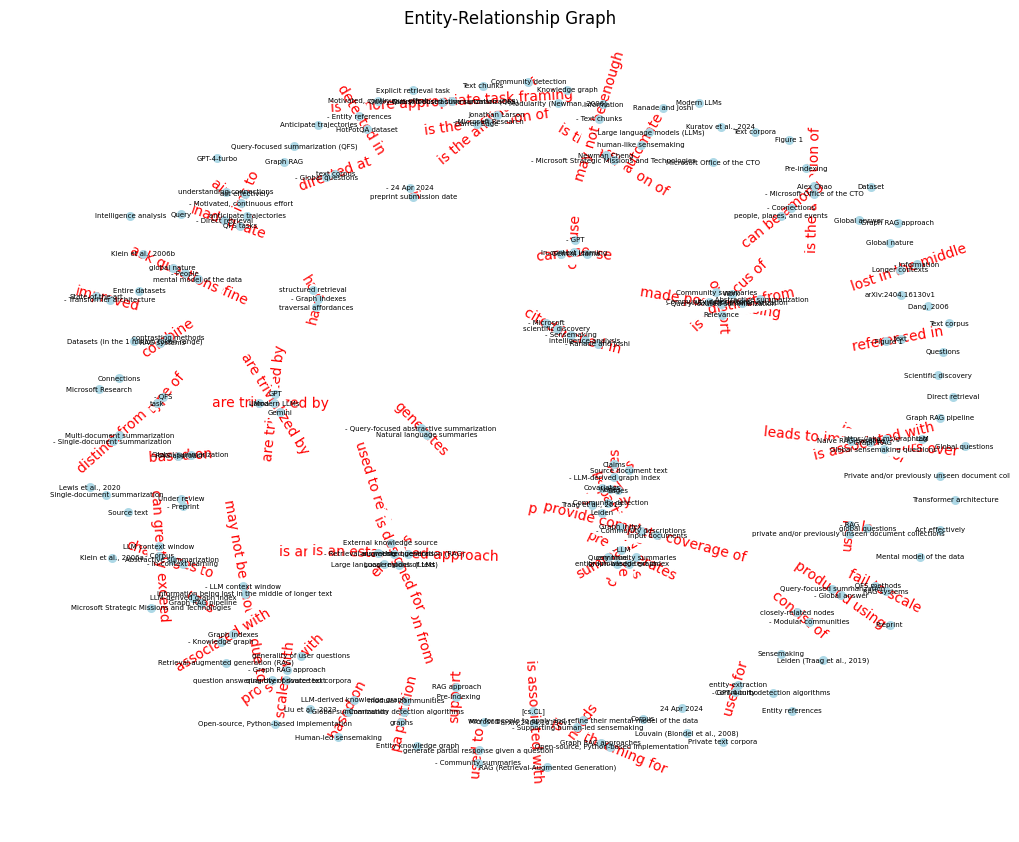

In [10]:
import matplotlib.pyplot as plt
pos = nx.spring_layout(graph)
labels = nx.get_edge_attributes(graph, 'label')

plt.figure(figsize=(10, 8))
nx.draw(graph, pos, with_labels=True, node_color='lightblue', node_size=30, font_size=5, edge_color='gray')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels, font_color='red')
plt.title("Entity-Relationship Graph")
plt.show()


In [11]:
def communities_detection(graph):
    """
    Detects communities in the graph using the Leiden algorithm.
    Each connected component is processed separately.
    """
    communities = []
    index = 0
    connected_components = list(nx.connected_components(graph))
    for component in connected_components:
        print(f"Component index {index} of {len(connected_components)}:")
        subgraph = graph.subgraph(component)
        if len(subgraph.nodes) > 1:
            try:
                sub_communities = algorithms.leiden(subgraph)
                for community in sub_communities.communities:
                    communities.append(list(community))
            except Exception as e:
                print(f"Error processing community {index}: {e}")
        else:
            communities.append(list(subgraph.nodes))
        index += 1
    print("Communities from detect_communities:", communities)
    return communities


communities = communities_detection(graph)

Component index 0 of 109:
Component index 1 of 109:
Error processing community 1: invalid literal for int() with base 10: 'User questions'
Component index 2 of 109:
Error processing community 2: invalid literal for int() with base 10: 'Query-focused summarization'
Component index 3 of 109:
Component index 4 of 109:
Component index 5 of 109:
Component index 6 of 109:
Error processing community 6: invalid literal for int() with base 10: 'Darren Edge'
Component index 7 of 109:
Error processing community 7: invalid literal for int() with base 10: '- Microsoft Strategic Missions and Technologies'
Component index 8 of 109:
Error processing community 8: invalid literal for int() with base 10: '- Microsoft Office of the CTO'
Component index 9 of 109:
Error processing community 9: invalid literal for int() with base 10: '- Query-focused summarization'
Component index 10 of 109:
Component index 11 of 109:
Component index 12 of 109:
Component index 13 of 109:
Component index 14 of 109:
Component 

`4. Graph Communities → Community Summaries`

  summarize each detected community.

In [12]:
def communities_summerization(communities, graph):
    """
      Creates a textual summary for each community based on its entities and their relationships.
      Inputs:
        communities (list of list): Communities detected from the graph.
        graph (networkx.Graph): The knowledge graph with edges and labels.
      Output:
        List of string summaries for each community.
    """
    community_summaries = []
    for index, community in enumerate(communities):
        print(f"Processing community {index + 1}/{len(communities)}")

        # Skip empty communities
        if not community:
            continue

        # Extract relationships within this community
        relationships = []
        for node1 in community:
            for node2 in community:
                if node1 != node2 and graph.has_edge(node1, node2):
                    label = graph.edges[node1, node2].get('label', 'related to')
                    relationships.append(f"{node1} -> {label} -> {node2}")

        # Create prompt for summarization
        community_text = "**Entities:**\n" + "\n".join([f"- {entity}" for entity in community])
        if relationships:
            community_text += "\n\n**Relationships:**\n" + "\n".join([f"- {rel}" for rel in relationships])

        # Use the LLM to generate a summary
        content = """Generate a concise summary of this community of related entities and their relationships.
Focus on identifying the main theme or concept that unites these entities, and explain how they relate to each other.
Keep your summary to 2-3 sentences and don't list all entities individually."""

        summary = get_response(community_text, content)
        community_summaries.append(summary)
            
        print(f"Community {index + 1} summary: {summary}")

    return community_summaries


community_summaries = communities_summerization(communities, graph)

Processing community 1/62
Community 1 summary: Retrieval-augmented generation (RAG) integrates information retrieval with language generation to enhance the accuracy and relevance of generated text by incorporating external data. It connects retrieval systems, which fetch relevant information from a database, with generation models, which produce coherent and contextually appropriate responses based on that retrieved information. This synergy allows for more informed and dynamic text generation.
Processing community 2/62
Community 2 summary: Microsoft Research is a central entity that drives innovation and exploration in technology and science. It connects with various academic, industrial, and collaborative entities through research initiatives, partnerships, and knowledge sharing, fostering advancement in computing and related fields.
Processing community 3/62
Community 3 summary: The community centered around Microsoft Strategic Missions and Technologies unites a set of initiatives 

`6. Community Summaries → Community Answers → Global Answer`

  Finally, we generate answers from community summaries and combine them into a final global answer.

In [13]:
def generate_final_answer(community_summaries, query):
    """
      Answers a query by using each community summary, then aggregates all answers.
      Inputs:
        community_summaries (list of str): Summaries of each community.
        query (str): The user query.
      Output:
        A final answer string synthesized from all community-based answers.
    """
    intermediate_answers = []
    for index, summary in enumerate(community_summaries):
        print(f"Summary index {index} of {len(community_summaries)}:")
        content = (
            f"Query: {query}\n\n"
            f"Summary: {summary}\n\n"
            "Address the query based solely on the information in this summary."
        )

        answer = get_response("Respond to the query using the provided summary information.", content).strip()
        print("Intermediate answer:", answer)
        intermediate_answers.append(answer)

    aggregation_prompt = (
            "As a knowledgeable assistant, integrate the following partial responses into one coherent, concise answer "
            "that fully addresses the original question.\n\n"
            f"Question: {query}\n\n"
            f"Partial Answers:\n" + "\n\n".join(f"- {ans}" for ans in intermediate_answers)
    )

    final_answer = get_response("Synthesize these responses into one comprehensive answer.", aggregation_prompt).strip()
    return final_answer

In [13]:
query = "What problem does Graph RAG aim to solve that traditional RAG and QFS methods cannot?"
print('Query:', query)
final_answer = generate_final_answer(community_summaries, query)
print("Answer: ", final_answer)

Query: What problem does Graph RAG aim to solve that traditional RAG and QFS methods cannot?
Summary index 0 of 52:
Intermediate answer: Graph RAG aims to solve the problem of limited contextual understanding and inefficient information retrieval in traditional RAG and QFS methods. By integrating graph structures, Graph RAG enhances the ability to capture complex relationships and dependencies within the retrieved information, leading to more accurate and contextually relevant generated text. This addresses the limitation of traditional methods in effectively utilizing and connecting diverse pieces of information for better contextual awareness and coherence.
Summary index 1 of 52:
Intermediate answer: The provided summary does not mention Graph RAG, traditional RAG, or QFS methods. Therefore, it cannot address the query about the problem that Graph RAG aims to solve that traditional RAG and QFS methods cannot.
Summary index 2 of 52:
Intermediate answer: Graph RAG aims to solve the pro

#### Analyze the proposed method for these questions. `10 pts`

- What problem does Graph RAG aim to solve that traditional RAG and QFS methods cannot?

- How does the Graph RAG architecture overcome the limitations of LLM context windows?

- What are the key steps in the Graph RAG pipeline, and how are they distributed between indexing time and query time?

- How does Graph RAG differ from previous QFS or graph-based retrieval approaches?

- What role do community detection algorithms (e.g., Leiden or Louvain) play in the Graph RAG framework?

- How does the performance of Graph RAG scale with increasing corpus size (e.g., 1M tokens)?

- What kind of summaries are generated during each stage of the Graph RAG pipeline, and how are they used?

- Why is the distinction between ‘local’ and ‘global’ queries important in the design of Graph RAG?

- How does entity extraction using GPT-4-turbo vary with chunk sizes in the HotPotQA dataset, as shown in Figure 2?

- Why do the authors claim that query-focused abstractive summarization is more appropriate than retrieval-based generation for global questions?

- In what ways does the modularity of graphs enable better summarization in the context of large corpora?

- How does Graph RAG contribute to the broader goal of sensemaking in domains like scientific discovery or intelligence analysis?

In [15]:
# List of questions to be answered
questions = [
    "What problem does Graph RAG aim to solve that traditional RAG and QFS methods cannot?",
    "How does the Graph RAG architecture overcome the limitations of LLM context windows?",
    "What are the key steps in the Graph RAG pipeline, and how are they distributed between indexing time and query time?",
    "How does Graph RAG differ from previous QFS or graph-based retrieval approaches?",
    "What role do community detection algorithms (e.g., Leiden or Louvain) play in the Graph RAG framework?",
    "How does the performance of Graph RAG scale with increasing corpus size (e.g., 1M tokens)?",
    "What kind of summaries are generated during each stage of the Graph RAG pipeline, and how are they used?",
    "Why is the distinction between 'local' and 'global' queries important in the design of Graph RAG?",
    "How does entity extraction using GPT-4-turbo vary with chunk sizes in the HotPotQA dataset, as shown in Figure 2?",
    "Why do the authors claim that query-focused abstractive summarization is more appropriate than retrieval-based generation for global questions?",
    "In what ways does the modularity of graphs enable better summarization in the context of large corpora?",
    "How does Graph RAG contribute to the broader goal of sensemaking in domains like scientific discovery or intelligence analysis?"
]

In [15]:
print(f"Question 1/{len(questions)}: {questions[0]}")
answer = generate_final_answer(community_summaries, questions[0])
print(answer)

Question 1/12: What problem does Graph RAG aim to solve that traditional RAG and QFS methods cannot?
Summary index 0 of 52:
Intermediate answer: Graph RAG aims to solve the problem of limited contextual and relational understanding in traditional RAG and QFS methods. While traditional RAG and QFS focus on retrieving and generating text based on flat, document-level information, Graph RAG enhances this by incorporating graph structures that capture complex relationships and contextual dependencies between entities, leading to more accurate and contextually rich generated text.
Summary index 1 of 52:
Intermediate answer: The provided summary does not mention Graph RAG, traditional RAG, or QFS methods. Therefore, it cannot address the query about the problem that Graph RAG aims to solve that traditional RAG and QFS methods cannot.
Summary index 2 of 52:
Intermediate answer: Graph RAG aims to solve the problem of efficiently capturing and utilizing complex relationships between entities in

In [ ]:
print(f"Question 2/{len(questions)}: {questions[1]}")
answer = generate_final_answer(community_summaries, questions[1])
print(answer)

In [ ]:
print(f"Question 3/{len(questions)}: {questions[2]}")
answer = generate_final_answer(community_summaries, questions[2])
print(answer)

In [ ]:
print(f"Question 4/{len(questions)}: {questions[3]}")
answer = generate_final_answer(community_summaries, questions[3])
print(answer)

In [ ]:
print(f"Question 5/{len(questions)}: {questions[4]}")
answer = generate_final_answer(community_summaries, questions[4])
print(answer)

In [ ]:
print(f"Question 6/{len(questions)}: {questions[5]}")
answer = generate_final_answer(community_summaries, questions[5])
print(answer)

In [ ]:
print(f"Question 7/{len(questions)}: {questions[6]}")
answer = generate_final_answer(community_summaries, questions[6])
print(answer)

In [ ]:
print(f"Question 8/{len(questions)}: {questions[7]}")
answer = generate_final_answer(community_summaries, questions[7])
print(answer)

In [ ]:
print(f"Question 9/{len(questions)}: {questions[8]}")
answer = generate_final_answer(community_summaries, questions[8])
print(answer)

In [ ]:
print(f"Question 10/{len(questions)}: {questions[9]}")
answer = generate_final_answer(community_summaries, questions[9])
print(answer)

In [ ]:
print(f"Question 11/{len(questions)}: {questions[10]}")
answer = generate_final_answer(community_summaries, questions[10])
print(answer)

In [ ]:
print(f"Question 12/{len(questions)}: {questions[11]}")
answer = generate_final_answer(community_summaries, questions[11])
print(answer)